<h1><center>ALGORITHMIC TRADING WITH NEURAL NETWORKS </center></h1>
<h2><center>AN EXAMPLE USING KERAS </center></h2>


## 1. PREPARING THE DATA


From: https://www.kaggle.com/fedewole/algorithmic-trading-with-keras-using-lstm/notebook

Algorithmic trading with Keras (using LSTM)

We use a Long Short Time Memory recurrent neural network to develop a good trading strategy for the S&P 500 index: the first trading day of each month we want our model to tell us if we are going to stay in the market for the current month or not.

We verify that, in a period running between 1982 and 2019,  which comprehends the 2008 crisis, this LSTM-trading-strategy is far better than the buy and hold strategy (stay always in the market) and the moving average strategy (buy when the current price is greater or equal to the moving average of past 12 months and sell otherwise).

We compute the gross and net yield ( 10% tax on capital gain and 0.10% fee to the broker at each transaction): our model performed roughly a 10% net annual yield (which is not bad, considering the 2008 crisis)

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
    
restartkernel()

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import yfinance

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

D:\Program Files\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Part 1: Get the data


I used Yahoo Finance to get the data of the S&P 500 index from 1973/1/1 to 2011/3/31. Our analysis is monthly-based, and all the decisions are made the first trading day of the month. For a reason which will be clarified by the following code, our analysis will start from 24 months after January 1973 and end the month before March 2011.

Since it is not possible to use Yahoo Finance on this kernel, I saved the data in "GSPC.csv". I still left the original code commented.

In [2]:
start_date=datetime.datetime(2000, 1, 1)
end_date=datetime.datetime(2019,12,31)

In [3]:
from pandas_datareader import data as pdr
import fix_yahoo_finance

df = pdr.get_data_yahoo('^GSPC', 
                          start=start_date, 
                          end=end_date)
df.head()

D:\Program Files\Anaconda\lib\site-packages\fix_yahoo_finance\__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,1478.000000,1438.359985,1469.250000,1455.219971,931800000,1455.219971
2000-01-04,1455.219971,1397.430054,1455.219971,1399.420044,1009000000,1399.420044
2000-01-05,1413.270020,1377.680054,1399.420044,1402.109985,1085500000,1402.109985
2000-01-06,1411.900024,1392.099976,1402.109985,1403.449951,1092300000,1403.449951
2000-01-07,1441.469971,1400.729980,1403.449951,1441.469971,1225200000,1441.469971


In [4]:
dfm=df.resample("M").mean()

dfm=dfm[:-1] # As we said, we do not consider the month of end_date

print(dfm.head())
print(dfm.tail())

                   High          Low         Open        Close        Volume  \
Date                                                                           
2000-01-31  1441.554498  1411.536011  1429.325006  1425.585504  1.074720e+09   
2000-02-29  1401.426501  1375.809497  1390.275995  1388.874500  1.045600e+09   
2000-03-31  1455.719562  1423.886947  1436.466951  1442.212599  1.137226e+09   
2000-04-30  1479.054206  1440.670005  1463.784726  1461.355257  1.058235e+09   
2000-05-31  1433.121377  1403.576372  1419.925914  1418.479548  9.044682e+08   

              Adj Close  
Date                     
2000-01-31  1425.585504  
2000-02-29  1388.874500  
2000-03-31  1442.212599  
2000-04-30  1461.355257  
2000-05-31  1418.479548  
                   High          Low         Open        Close        Volume  \
Date                                                                           
2019-07-31  3003.907726  2984.145020  2995.792281  2996.113636  3.197703e+09   
2019-08-31  2917.

In [5]:
start_year=start_date.year
start_month=start_date.month
end_year=end_date.year
end_month=end_date.month

In [6]:
first_days=[]
# First year
for month in range(start_month,13):
    first_days.append(min(df[str(start_year)+"-"+str(month)].index))
# Other years
for year in range(start_year+1,end_year):
    for month in range(1,13):
        first_days.append(min(df[str(year)+"-"+str(month)].index))
# Last year
for month in range(1,end_month+1):
    first_days.append(min(df[str(end_year)+"-"+str(month)].index))

Now for each month we have the means of the month, the first trading day of the current month (and its open price) and the first trading day of the next month (and its open price).

The feature rapp is the quotient between the open price of the first trading day of the next month and the open price of the first trading day of the current month. It will be used because it gives the variation of the portfolio for the current month

In [7]:
dfm["fd_cm"]=first_days[:-1]
dfm["fd_nm"]=first_days[1:]
dfm["fd_cm_open"]=np.array(df.loc[first_days[:-1],"Open"])
dfm["fd_nm_open"]=np.array(df.loc[first_days[1:],"Open"])
dfm["rapp"]=dfm["fd_nm_open"].divide(dfm["fd_cm_open"])

In [8]:
dfm["mv_avg_12"]= dfm["Open"].rolling(window=12).mean().shift(1)
dfm["mv_avg_24"]= dfm["Open"].rolling(window=24).mean().shift(1)

In [9]:
dfm

,High,Low,Open,Close,Volume,Adj Close,fd_cm,fd_nm,fd_cm_open,fd_nm_open,rapp,mv_avg_12,mv_avg_24
Date,,,,,,,,,,,,,
2000-01-31,1441.554498,1411.536011,1429.325006,1425.585504,1.074720e+09,1425.585504,2000-01-03,2000-02-01,1469.250000,1394.459961,0.949096,NaN,NaN
2000-02-29,1401.426501,1375.809497,1390.275995,1388.874500,1.045600e+09,1388.874500,2000-02-01,2000-03-01,1394.459961,1366.420044,0.979892,NaN,NaN
2000-03-31,1455.719562,1423.886947,1436.466951,1442.212599,1.137226e+09,1442.212599,2000-03-01,2000-04-03,1366.420044,1498.579956,1.096720,NaN,NaN
2000-04-30,1479.054206,1440.670005,1463.784726,1461.355257,1.058235e+09,1461.355257,2000-04-03,2000-05-01,1498.579956,1452.430054,0.969204,NaN,NaN
2000-05-31,1433.121377,1403.576372,1419.925914,1418.479548,9.044682e+08,1418.479548,2000-05-01,2000-06-01,1452.430054,1420.599976,0.978085,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31,3003.907726,2984.145020,2995.792281,2996.113636,3.197703e+09,2996.113636,2019-07-01,2019-08-01,2971.409912,2980.320068,1.002999,2786.464017,2706.934349
2019-08-31,2917.818626,2876.744995,2901.219993,2897.450451,3.618156e+09,2897.450451,2019-08-01,2019-09-03,2980.320068,2909.010010,0.976073,2803.651944,2729.549049
2019-09-30,2992.096008,2968.614502,2982.082996,2982.156006,3.699616e+09,2982.156006,2019-09-03,2019-10-01,2909.010010,2983.689941,1.025672,2807.541473,2748.068633


In [26]:
print(dfm.loc["2003-01","mv_avg_12"])
print(dfm.loc["2003-01":"2019-02","Open"])
print(dfm.loc["2003-01":"2019-02","Open"].mean())

Date
2003-01-31    996.685287
Freq: M, Name: mv_avg_12, dtype: float64
Date
2003-01-31     896.985238
2003-02-28     838.384740
2003-03-31     846.294285
2003-04-30     886.752380
2003-05-31     933.740470
                 ...     
2018-10-31    2796.075662
2018-11-30    2719.651902
2018-12-31    2580.702624
2019-01-31    2597.898589
2019-02-28    2750.142141
Freq: M, Name: Open, Length: 194, dtype: float64
1571.4547251299973


We remove the first 24 months, since they do not have the 2-year moving average

In [11]:
dfm=dfm.iloc[24:,:] # WARNING: DO IT JUST ONE TIME!
print(dfm.index)

DatetimeIndex(['2002-01-31', '2002-02-28', '2002-03-31', '2002-04-30',
               '2002-05-31', '2002-06-30', '2002-07-31', '2002-08-31',
               '2002-09-30', '2002-10-31',
               ...
               '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31',
               '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30',
               '2019-10-31', '2019-11-30'],
              dtype='datetime64[ns]', name='Date', length=215, freq='M')


In [12]:
dfm

,High,Low,Open,Close,Volume,Adj Close,fd_cm,fd_nm,fd_cm_open,fd_nm_open,rapp,mv_avg_12,mv_avg_24
Date,,,,,,,,,,,,,
2002-01-31,1148.500959,1132.814290,1141.059053,1140.207624,1.416486e+09,1140.207624,2002-01-02,2002-02-01,1148.079956,1130.199951,0.984426,1192.919552,1310.205749
2002-02-28,1110.244738,1092.733681,1101.904201,1100.668939,1.370926e+09,1100.668939,2002-02-01,2002-03-01,1130.199951,1106.729980,0.979234,1176.885385,1298.194668
2002-03-31,1160.426489,1145.429993,1151.758002,1153.791003,1.328160e+09,1153.791003,2002-03-01,2002-04-01,1106.729980,1147.390015,1.036739,1159.344244,1286.179176
2002-04-30,1120.898182,1105.535012,1115.237721,1112.034540,1.298586e+09,1112.034540,2002-04-01,2002-05-01,1147.390015,1076.920044,0.938582,1156.201690,1274.316303
2002-05-31,1087.789545,1070.872736,1079.711825,1079.267278,1.222977e+09,1079.267278,2002-05-01,2002-06-03,1076.920044,1067.140015,0.990919,1150.356417,1259.793512
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31,3003.907726,2984.145020,2995.792281,2996.113636,3.197703e+09,2996.113636,2019-07-01,2019-08-01,2971.409912,2980.320068,1.002999,2786.464017,2706.934349
2019-08-31,2917.818626,2876.744995,2901.219993,2897.450451,3.618156e+09,2897.450451,2019-08-01,2019-09-03,2980.320068,2909.010010,0.976073,2803.651944,2729.549049
2019-09-30,2992.096008,2968.614502,2982.082996,2982.156006,3.699616e+09,2982.156006,2019-09-03,2019-10-01,2909.010010,2983.689941,1.025672,2807.541473,2748.068633


## 2. TRAINING AND TESTING DATA SETS

In [13]:
mtest=72
train=dfm.iloc[:-mtest,:] 
test=dfm.iloc[-mtest:,:] 

In [14]:
def yield_gross(df,v):
    prod=(v*df["rapp"]+1-v).prod()
    n_years=len(v)/12
    return (prod-1)*100,((prod**(1/n_years))-1)*100

In [15]:
tax_cg=0.10
comm_bk=0.001

## 3. LABELING

### 3.1. THE EXPAND ISLANDS ALGORITHM

Given any vector v of ones and zeros, this function gives the corresponding vectors of "islands" of ones of v
and their number. 

For example, given v = [0,1,1,0,1,0,1], expand_islands2D gives
out2D = [[0,1,1,0,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,0,1]] and N=3

In [16]:
def expand_islands2D(v):
    
    # Get start, stop of 1s islands
    v1 = np.r_[0,v,0]
    idx = np.flatnonzero(v1[:-1] != v1[1:])
    s0,s1 = idx[::2],idx[1::2]
    if len(s0)==0:
        return np.zeros(len(v)),0
    
    # Initialize 1D id array  of size same as expected o/p and has 
    # starts and stops assigned as 1s and -1s, so that a final cumsum
    # gives us the desired o/p
    N,M = len(s0),len(v)
    out = np.zeros(N*M,dtype=int)

    # Setup starts with 1s
    r = np.arange(N)*M
    out[s0+r] = 1


    # Setup stops with -1s
    if s1[-1] == M:
        out[s1[:-1]+r[:-1]] = -1
    else:
        out[s1+r] -= 1

    # Final cumsum on ID array
    out2D = out.cumsum().reshape(N,-1)
    return out2D,N

In [17]:
v = [0,1,1,0,1,0,1]
expand_islands2D(v)

(array([[0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]], dtype=int32), 3)

This function returns the total percentage net yield and the annual percentage net yield

In [18]:
def yield_net(df,v):
    n_years=len(v)/12
    
    w,n=expand_islands2D(v)
    A=(w*np.array(df["rapp"])+(1-w)).prod(axis=1)  # A is the product of each island of ones of 1 for df["rapp"]
    A1p=np.maximum(0,np.sign(A-1)) # vector of ones where the corresponding element if  A  is > 1, other are 0
    Ap=A*A1p # vector of elements of A > 1, other are 0
    Am=A-Ap # vector of elements of A <= 1, other are 0
    An=Am+(Ap-A1p)*(1-tax_cg)+A1p
    prod=An.prod()*((1-comm_bk)**(2*n)) 
    
    return (prod-1)*100,((prod**(1/n_years))-1)*100   


We want to use a LSTM neural network to decide, the first day of each day of the test period, whether we are going to stay in the market for the month or not.

**We reshape the data (the LSTM wants the data in a particular shape, involving "windows") and at each step we want to predict the opening price of the first day of the next month: in this way we will be able to find the vector v which selects the months during which we are going to stay in the market**

In [19]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

In [20]:
scaler=MinMaxScaler(feature_range=(0,1))
dg=pd.DataFrame(scaler.fit_transform(dfm[["High","Low","Open","Close","Volume","fd_cm_open",\
                                          "mv_avg_12","mv_avg_24","fd_nm_open"]].values))
dg0=dg[[0,1,2,3,4,5,6,7]]


window=4
dfw=create_window(dg0,window)

X_dfw=np.reshape(dfw.values,(dfw.shape[0],window+1,8))
print(X_dfw.shape)
print(dfw.iloc[:4,:])
print(X_dfw[0,:,:])

y_dfw=np.array(dg[8][window:])

(211, 5, 8)
          0         1         2         3         4         5         6  \
0  0.161904  0.165835  0.164828  0.163167  0.037535  0.180303  0.153934   
1  0.145553  0.148791  0.148148  0.146327  0.030153  0.172600  0.145644   
2  0.167001  0.171200  0.169386  0.168953  0.023223  0.162488  0.136575   
3  0.150107  0.154234  0.153828  0.151168  0.018432  0.180006  0.134950   

          7         0         1  ...         6         7         0         1  \
0  0.183116  0.145553  0.148791  ...  0.134950  0.163251  0.135956  0.139494   
1  0.176468  0.167001  0.171200  ...  0.131928  0.155213  0.109205  0.110964   
2  0.169817  0.150107  0.154234  ...  0.123719  0.147366  0.063632  0.061361   
3  0.163251  0.135956  0.139494  ...  0.114141  0.137161  0.065759  0.066298   

          2         3         4         5         6         7  
0  0.138694  0.137211  0.006181  0.149646  0.131928  0.155213  
1  0.112361  0.109432  0.050917  0.145432  0.123719  0.147366  
2  0.065169  0.0623

In [21]:
X_trainw=X_dfw[:-mtest-1,:,:]
X_testw=X_dfw[-mtest-1:,:,:]
y_trainw=y_dfw[:-mtest-1]
y_testw=y_dfw[-mtest-1:]

### 3.2. DEFINING THE MODEL WITH THE KERAS API

In [22]:
def model_lstm(window,features):
    
    model=Sequential()
    model.add(LSTM(300, input_shape = (window,features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200, input_shape=(window,features), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam')
    
    
    return model

In [23]:
model=model_lstm(window+1,8)
history=model.fit(X_trainw,y_trainw,epochs=500, batch_size=24, validation_data=(X_testw, y_testw), \
                  verbose=0, callbacks=[],shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


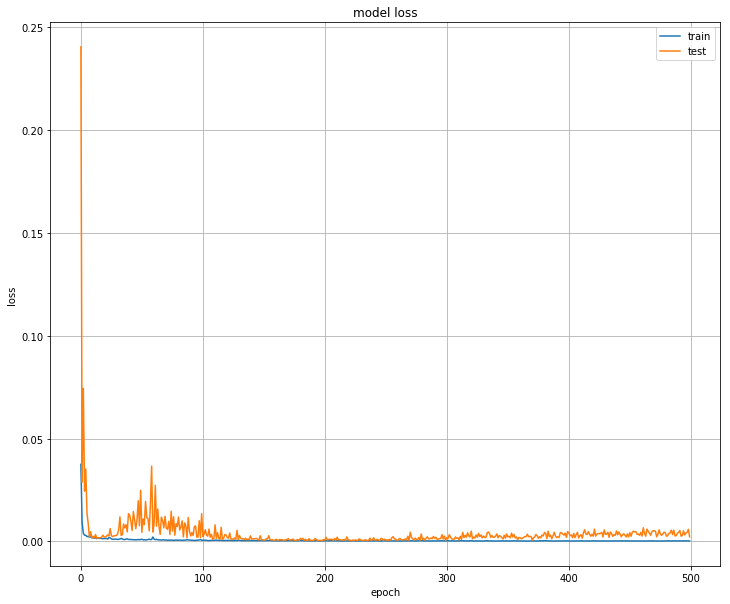

In [39]:
plt.figure(figsize=(12,10))
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## 4. MODEL PERFORMANCE

In [30]:
y_pr=model.predict(X_trainw)

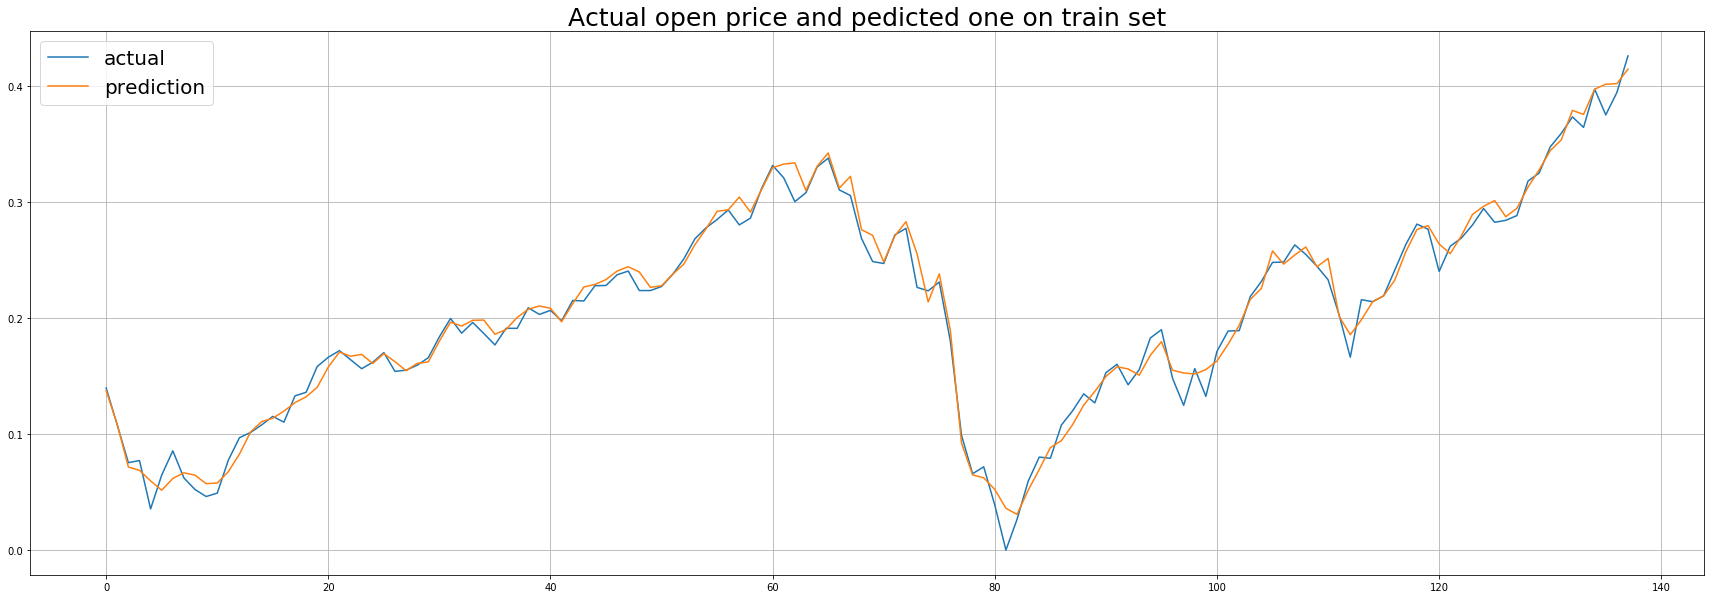

In [31]:
plt.figure(figsize=(30,10))
plt.plot(y_trainw, label="actual")
plt.plot(y_pr, label="prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show()

In [32]:
y_pred=model.predict(X_testw)

We stay in the market when the predicted price for the next month is greater than the current price and stay out otherwise. The vector v indicates the "in months" (as 1s) and "out months" (as 0s)

In [33]:
v=np.diff(y_pred.reshape(y_pred.shape[0]),1)
v_lstm=np.maximum(np.sign(v),0)

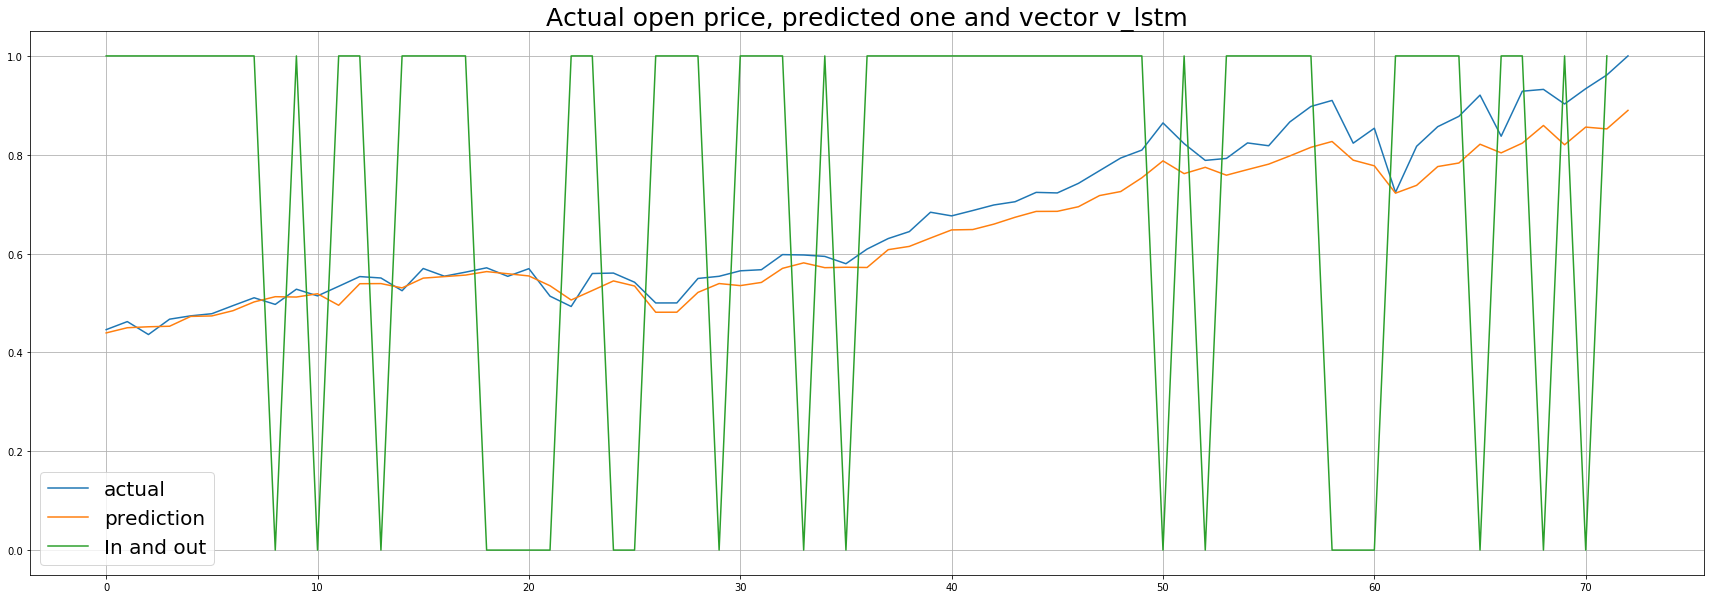

In [34]:
plt.figure(figsize=(30,10))
plt.plot(y_testw, label="actual")
plt.plot(y_pred, label="prediction")
plt.plot(v_lstm,label="In and out")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price, predicted one and vector v_lstm",fontsize=25)
plt.show()

Now we can copare our LSTM-trading-strategy with the buy and hold strategy and the moving average strategy. In order to do so we compute the corresponding vectors v_bh and v_ma which select the months during which we are going to stay in the market.

In [35]:
v_bh=np.ones(test.shape[0])
v_ma=test["fd_cm_open"]>test["mv_avg_12"]

In [36]:
def gross_portfolio(df,w):
    portfolio=[ (w*df["rapp"]+(1-w))[:i].prod() for i in range(len(w))]
    return portfolio

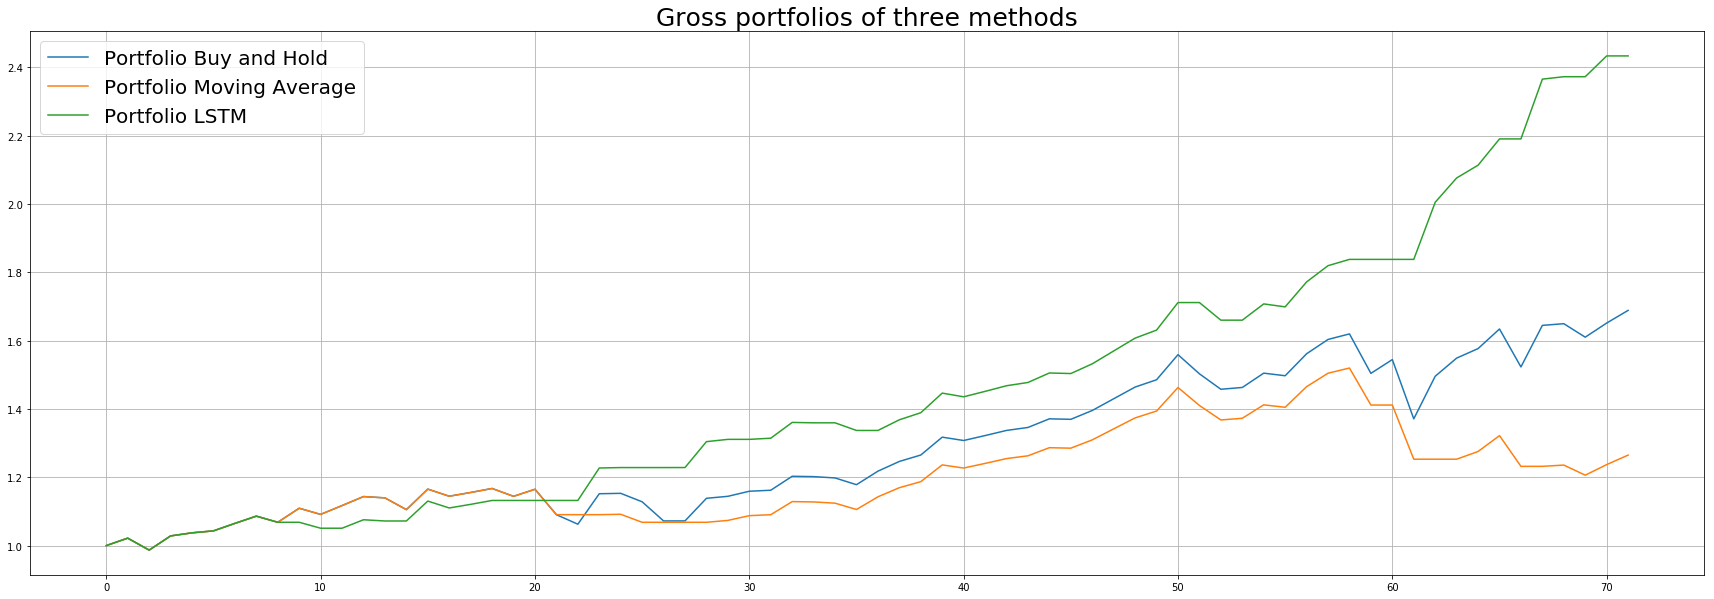

In [37]:
plt.figure(figsize=(30,10))
plt.plot(gross_portfolio(test,v_bh),label="Portfolio Buy and Hold")
plt.plot(gross_portfolio(test,v_ma),label="Portfolio Moving Average")
plt.plot(gross_portfolio(test,v_lstm),label="Portfolio LSTM")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Gross portfolios of three methods", fontsize=25)
plt.show()

In [40]:
print("Test period of {:.2f} years, from {} to {} \n".format(len(v_bh)/12,str(test.loc[test.index[0],"fd_cm"])[:10],\
      str(test.loc[test.index[-1],"fd_nm"])[:10]))

results0=pd.DataFrame({})
results1=pd.DataFrame({})
results2=pd.DataFrame({})
results3=pd.DataFrame({})

results0["Method"]=["Buy and hold","Moving average","LSTM"]
results1["Method"]=["Buy and hold","Moving average","LSTM"]
results2["Method"]=["Buy and hold","Moving average","LSTM"]
results3["Method"]=["Buy and hold","Moving average","LSTM"]

vs=[v_bh,v_ma,v_lstm]
results0["Total gross yield"]=[str(round(yield_gross(test,vi)[0],2))+" %" for vi in vs]
results1["Annual gross yield"]=[str(round(yield_gross(test,vi)[1],2))+" %" for vi in vs]
results2["Total net yield"]=[str(round(yield_net(test,vi)[0],2))+" %" for vi in vs]
results3["Annual net yield"]=[str(round(yield_net(test,vi)[1],2))+" %" for vi in vs]

print(results0)
print("\n")
print(results1)
print("\n")
print(results2)
print("\n")
print(results3)

Test period of 6.00 years, from 2013-12-02 to 2019-12-02 

           Method Total gross yield
0    Buy and hold           74.03 %
1  Moving average           30.35 %
2            LSTM          150.82 %


           Method Annual gross yield
0    Buy and hold             9.67 %
1  Moving average             4.52 %
2            LSTM            16.56 %


           Method Total net yield
0    Buy and hold         66.29 %
1  Moving average         23.94 %
2            LSTM        121.84 %


           Method Annual net yield
0    Buy and hold           8.85 %
1  Moving average           3.64 %
2            LSTM           14.2 %
